# Imports and Data

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import datetime as dt
import os
import matplotlib.pyplot as plt
import phonecalls as pc
import scipy.stats as stats
import scipy.interpolate as interpol
import statsmodels.api as sm
import pymannkendall as mk
import time
import copy
import math
import pickle
import regress_k as jalg


plt.rcParams['figure.figsize'] = (20, 10)
markers = ['o', 'v', 's', 'P', '*', 'X', 'd', 'x', 'D', '2', '+']
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

with open('unfiltered.pkl', 'rb') as handle:
    unfiltered = pickle.load(handle)
handle.close()

with open('../itdata/mtl_unfiltered.pickle', 'rb') as handle:
    tmpunf = pickle.load(handle)
    handle.close()
    
unfiltered.update(tmpunf)

with open('../itdata/mtl_dffa15.pickle', 'rb') as handle:
    itdffa15 = pickle.load(handle)
    handle.close()
    
with open('../itdata/mtl_dffa30.pickle', 'rb') as handle:
    itdffa30 = pickle.load(handle)
    handle.close()
    
with open('../itdata/mtl_livesd.pickle', 'rb') as handle:
    itlives = pickle.load(handle)
    handle.close()
    
unfiltered['mit'] = pc.allcalls('../usadata/CallLog.csv', ('type', 'outgoing', 'outgoing+', 'missed'), 'participantID.A', 'number.hash', 
                                ['local_time'], "%Y-%m-%d %H:%M:%S", header=True, min_activity=1)
unfiltered['uk12'] = pd.DataFrame()
for c in ['uk1', 'uk2']:
    df = unfiltered[c].copy(deep=True)
    df['ego'] = df['ego'].map(lambda i: f'{dict({"uk1": "a", "uk2": "b"})[c]}{i}')
    unfiltered['uk12'] = unfiltered['uk12'].append(df)

L = {'uk': 300, 'uk1': 300, 'uk2': 270, 'it': 365, 'itb': 365, 'mit': 220}
calls = {}
for c in ['uk', 'uk1', 'uk2', 'it', 'mit']:
    df = unfiltered[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    lf = df.groupby('ea')[['aclock']].max()
    keep = lf.loc[lf['aclock'] <= L[c]]
    df = df[df['ea'].isin(keep.index)]
    calls[c] = pc.apply_filters(df, 60)
calls['uk12'] = pd.DataFrame()
for c in ['uk1', 'uk2']:
    df = calls[c].copy(deep=True)
    df['ego'] = df['ego'].map(lambda i: f'{dict({"uk1": "a", "uk2": "b"})[c]}{i}')
    calls['uk12'] = calls['uk12'].append(df)
    
    
globalt0 = dt.datetime.now()

/opt/homebrew/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Working as expected


In [2]:
for c in ['it', 'mit']:
    # No Filter
    df = unfiltered[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    print(c, len(df['ea'].unique()))
    # L
    lf = df.groupby('ea')[['aclock']].max()
    keep = lf.loc[lf['aclock'] <= L[c]]
    df = df[df['ea'].isin(keep.index)]
    print(c, len(df['ea'].unique()))
    # ncalls = df.groupby('ea')[['time']].count()
    # keep = ncalls.loc[ncalls['time'] >= 3]
    # df = df[df['ea'].isin(keep.index)]
    # calls[{'it': 'itL', 'mit': 'mitL'}[c]] = df
    # print(c, len(df['ea'].unique()))
    # Delta t to the left (by ego)
    t0i = df.groupby('ego')['uclock'].min()
    t0x = df.groupby('ea')[['uclock']].min()
    t0x['dif'] = t0x.index.map(lambda i: t0x.at[i, 'uclock'] - t0i[i[0]])
    keep = t0x.loc[t0x['dif'] > 50]
    df = df[df['ea'].isin(keep.index)]
    print(len(df['ea'].unique()))
    # Delta t to the right
    df = pc.apply_filters(df, 60)
    df['ea'] = list(zip(df['ego'], df['alter']))
    calls[{'it': 'itb', 'mit': 'mitb'}[c]] = df

it 23674
it 21064
17501
mit 4145
mit 4063
2666


#  Obtain cumulative of $f_{ix}$

In [3]:
limits = {}
for c in ['uk2', 'itb', 'it', 'mit']:
    limits[c] = []
    limits[c].append((0, 50))
    limits[c].append((L[c] // 2 - 25, L[c]//2 + 25))
    limits[c].append((L[c] - 50, L[c]))
limits

{'uk2': [(0, 50), (110, 160), (220, 270)],
 'itb': [(0, 50), (157, 207), (315, 365)],
 'it': [(0, 50), (157, 207), (315, 365)],
 'mit': [(0, 50), (85, 135), (170, 220)]}

In [4]:
test = calls['uk2'].copy(deep=True)
test.head()

,ego,alter,time,uclock,aclock
0,C07779270485,C01132304499,2007-09-26 08:42:00,24,0
1,C07779270485,C01132304499,2007-10-05 14:32:00,33,9
2,C07779270485,C01132304499,2007-10-27 01:11:00,55,31
3,C07779270485,C01132304499,2008-01-09 20:35:00,130,106
4,C07779270485,C01132416800,2008-05-06 02:16:00,247,0


In [5]:
test['ea'] = list(zip(test['ego'], test['alter']))
test.head()

,ego,alter,time,uclock,aclock,ea
0,C07779270485,C01132304499,2007-09-26 08:42:00,24,0,"(C07779270485, C01132304499)"
1,C07779270485,C01132304499,2007-10-05 14:32:00,33,9,"(C07779270485, C01132304499)"
2,C07779270485,C01132304499,2007-10-27 01:11:00,55,31,"(C07779270485, C01132304499)"
3,C07779270485,C01132304499,2008-01-09 20:35:00,130,106,"(C07779270485, C01132304499)"
4,C07779270485,C01132416800,2008-05-06 02:16:00,247,0,"(C07779270485, C01132416800)"


In [6]:
nix = test.groupby('ea')[['time']].count()
nix = nix.loc[nix['time'] >= 10]
allties = list(nix.index)

In [7]:
subtest = test.loc[test['ea'] == allties[30]]
subtest.head()

,ego,alter,time,uclock,aclock,ea
1068,C07792658311,C01865777333,2007-10-19 14:39:00,47,0,"(C07792658311, C01865777333)"
1069,C07792658311,C01865777333,2007-10-21 19:21:00,50,3,"(C07792658311, C01865777333)"
1070,C07792658311,C01865777333,2008-01-24 19:02:00,145,98,"(C07792658311, C01865777333)"
1071,C07792658311,C01865777333,2008-01-24 20:13:00,145,98,"(C07792658311, C01865777333)"
1072,C07792658311,C01865777333,2008-01-26 09:52:00,146,99,"(C07792658311, C01865777333)"


In [8]:
subtest2 = subtest.groupby('aclock')[['time']].count()

In [9]:
subtest2['cumulative'] = subtest2['time'].cumsum()
subtest2.head()

,time,cumulative
aclock,,
0,1,1
3,1,2
98,2,4
99,1,5
228,1,6


In [10]:
subtest2['cmf'] = subtest2['cumulative'].div(sum(subtest2['time']))
subtest2.head()

,time,cumulative,cmf
aclock,,,
0,1,1,0.083333
3,1,2,0.166667
98,2,4,0.333333
99,1,5,0.416667
228,1,6,0.500000


In [11]:
X = list(subtest2.index)
Y = list(subtest2['cmf'])
X = sm.add_constant(X)

In [12]:
fitted = sm.OLS(Y, X).fit()
fitted.summary()

/opt/homebrew/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     26.76
Date:                Fri, 11 Mar 2022   Prob (F-statistic):            0.00207
Time:                        20:47:34   Log-Likelihood:                 5.1353
No. Observations:                   8   AIC:                            -6.271
Df Residuals:                       6   BIC:                            -6.112
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1102      0.092      1.203      0.274      -0.114       0.334
x1             0.0028      0.001      5.173      0.002       0.001       0.004
==============================================================================
Omnibus:                        0.968   Durbin-Watson:                   1.310
Prob(Omnibus):                  0.616   Jarque-Bera (JB):                0.019
Skew:                          -0.118   Prob(JB):                        0.990
Kurtosis:                       2.947   Cond. No.                         301.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
subtest3 = pc.get_fal(subtest, 0, 500, 15)

In [14]:
fitted.rsquared

0.8168431274905408

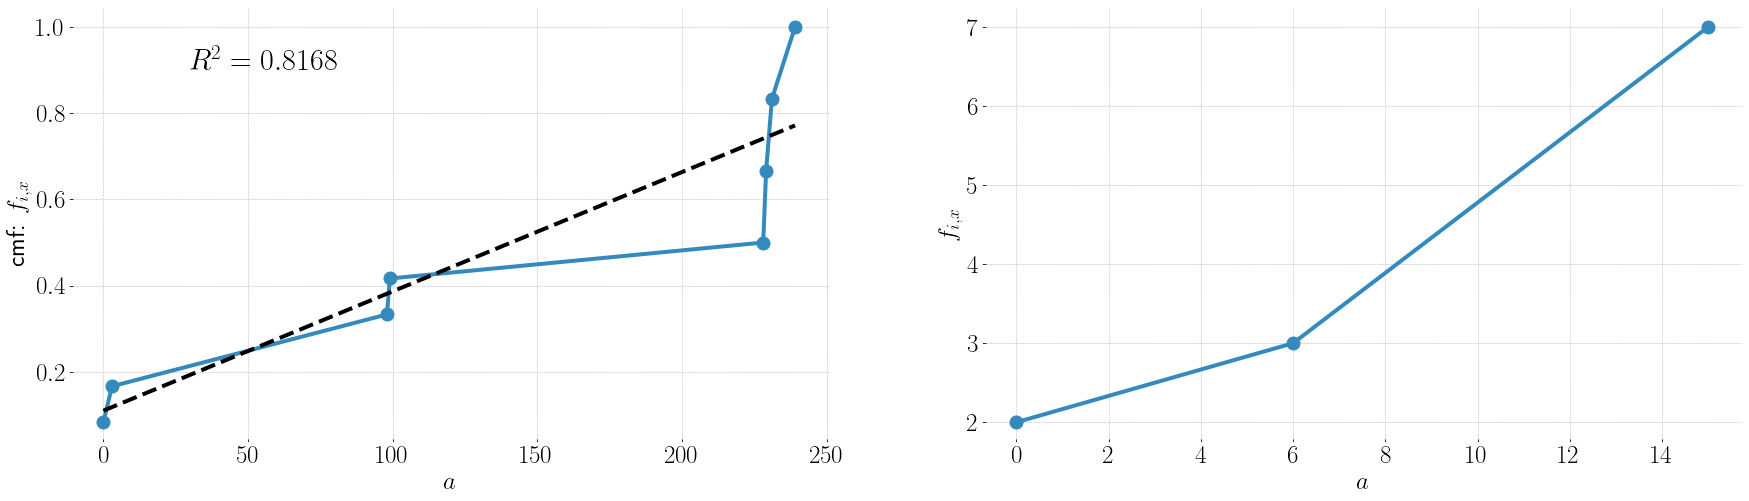

In [15]:
plt.figure(figsize=(30, 8))

plt.subplot(121)
plt.xlabel(r"$a$")
plt.ylabel(r"cmf: $f_{i,x}$")
plt.plot(subtest2.index, subtest2['cmf'], marker=markers[0], markersize=13, ls='solid', lw=4)
plt.plot(subtest2.index, [fitted.params[0] + fitted.params[1] * x for x in subtest2.index], marker="", ls="dashed", c="black", lw=4)
plt.annotate(fr"$R^{{2}} = {fitted.rsquared:.4f}$", (30, 0.9), fontsize=30)

plt.subplot(122)
plt.xlabel(r"$a$")
plt.ylabel(r"$f_{i,x}$")
plt.plot(subtest3['f'].index, subtest3['f']['f'], marker=markers[0], markersize=13, ls='solid', lw=4)

## Multiple ties

In [16]:
ncalls = test.groupby('ea')[['time']].count()
ncalls = ncalls.sort_values(by='time', ascending=False)
ncalls.head()

,time
ea,
"(C07800650314, C27727579975)",532
"(C07817280467, C07975653749)",436
"(C07814508939, C07769801666)",355
"(C07800643466, C07768712580)",350
"(C07800643466, C07967999632)",325


In [137]:
alter_sample = list(ncalls.index)[0:10]
len(alter_sample)

10

In [138]:
cumuanalysis = {}
for tie in alter_sample:
    cumuanalysis[tie] = {}
    subtest = test.loc[test['ea'] == tie]
    subtest2 = subtest.groupby('aclock')[['time']].count()
    subtest2['cumulative'] = subtest2['time'].cumsum()
    subtest2['cmf'] = subtest2['cumulative'].div(sum(subtest2['time']))
    df = subtest2[['cmf']]
    cumuanalysis[tie]['cmf'] = df
    X = list(subtest2.index)
    Y = list(subtest2['cmf'])
    X = sm.add_constant(X)
    fitted = sm.OLS(Y, X).fit()
    cumuanalysis[tie]['fitted'] = pd.DataFrame({'X': df.index, 'Y': [fitted.params[0] + fitted.params[1] * x for x in df.index]})
    cumuanalysis[tie]['rsq'] = fitted.rsquared
    subtest3 = pc.get_fal(subtest, 0, 500, 1)
    cumuanalysis[tie]['fix'] = subtest3['f'].copy()

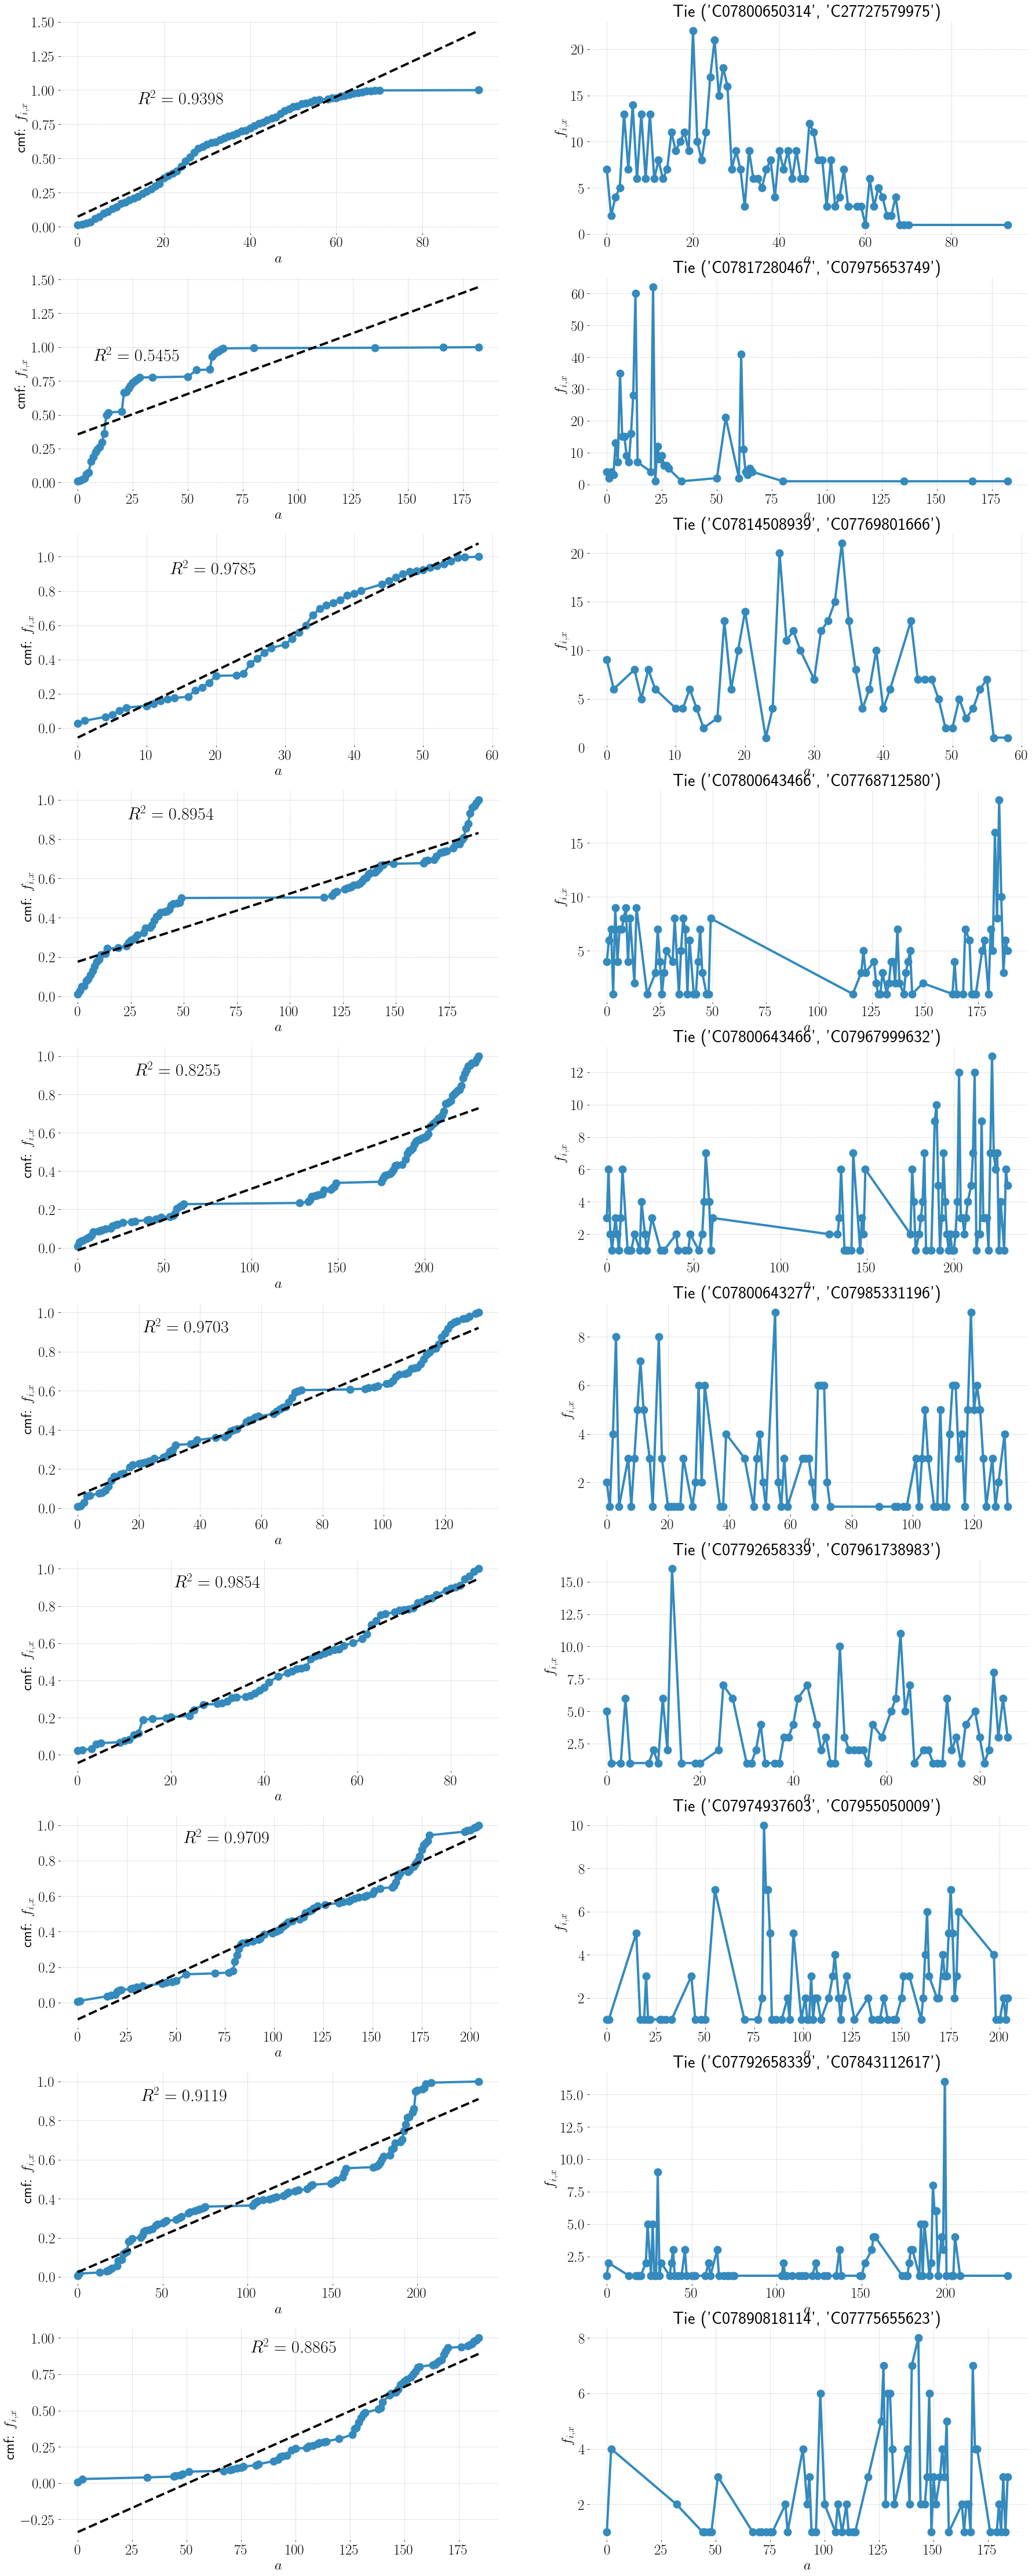

In [139]:
nr = len(cumuanalysis.keys())
nc = 2
plt.figure(figsize=(15*nc, 8*nr))
p = 1
for tie in cumuanalysis.keys():
    plt.subplot(nr, nc, p)
    plt.xlabel(r"$a$")
    plt.ylabel(r"cmf: $f_{i,x}$")
    plt.plot(cumuanalysis[tie]['cmf'].index, cumuanalysis[tie]['cmf']['cmf'], marker=markers[0], markersize=13, ls='solid', lw=4)
    plt.plot(cumuanalysis[tie]['fitted']['X'], cumuanalysis[tie]['fitted']['Y'], marker="", ls="dashed", c="black", lw=4)
    plt.annotate(fr"$R^{{2}} = {cumuanalysis[tie]['rsq']:.4f}$", (np.percentile(cumuanalysis[tie]['cmf'].index, 20), 0.9), fontsize=30)
    p += 1
    
    plt.subplot(nr, nc, p)
    plt.title(f"Tie {tie}")
    plt.xlabel(r"$a$")
    plt.ylabel(r"$f_{i,x}$")
    plt.plot([(x * 1) + 0 for x in cumuanalysis[tie]['fix'].index], cumuanalysis[tie]['fix']['f'], marker=markers[0], markersize=13, ls='solid', lw=4)
    p += 1

# Trying Jericho's algorithm

To find multiple slopes in pieces of each series. I need a series to test this.

In [133]:
calls['uk2'].groupby('pair')[['date']].count()

KeyError: 'pair'

In [70]:
ts = cumuanalysis[list(cumuanalysis.keys())[1]]
ts['cmf']

,cmf
aclock,
0,0.086957
1,0.173913
29,0.304348
30,0.391304
32,0.826087
33,0.956522
34,1.000000


In [21]:
X = np.matrix(ts['cmf'].index)
X = np.matrix(sm.add_constant(X))
Xt = np.matrix.getT(X)
Y = np.matrix.getT(np.matrix(ts['cmf']['cmf']))

In [22]:
Xt

matrix([[  0],
        [ 26],
        [216],
        [220],
        [228],
        [233],
        [234],
        [237],
        [239]])

In [24]:
X = ts['cmf'].index
X = sm.add_constant(X)
Y = ts['cmf']['cmf']
model = sm.OLS(Y, X).fit()
model.summary()

/opt/homebrew/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cmf   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     4.402
Date:                Fri, 11 Mar 2022   Prob (F-statistic):             0.0741
Time:                        20:47:55   Log-Likelihood:                0.56789
No. Observations:                   9   AIC:                             2.864
Df Residuals:                       7   BIC:                             3.259
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0109      0.192      0.057      0.956      -0.444       0.466
x1             0.0020      0.001      2.098      0.074      -0.000       0.004
==============================================================================
Omnibus:                        4.285   Durbin-Watson:                   0.616
Prob(Omnibus):                  0.117   Jarque-Bera (JB):                1.315
Skew:                           0.909   Prob(JB):                        0.518
Kurtosis:                       3.451   Cond. No.                         454.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [112]:
def OLS(X, Y):
    result = {}
    X = np.array(X)
    ones = np.array([1 for _ in range(X.shape[0])])
    X = np.c_[ones, X]
    X = np.matrix(X)
    Y = np.matrix(Y)
    if Y.shape[1] > 1:
        Y = Y.getT()
    Xt = X.getT()
    tmpl = np.linalg.inv(np.matmul(Xt, X))
    tmpr = np.matmul(Xt, Y)
    coef = np.matmul(tmpl, tmpr)
    Yh = np.matmul(X, coef)
    res = abs(Y - Yh)
    result['coef'] = coef
    result['yh'] = Yh
    result['res'] = res
    result['sqe'] = np.array(res)**2
    result['mse'] = (sum(result['sqe']) / result['sqe'].shape[0])[0]
    avgY = np.mean(Y)
    SStot = sum(np.array(Y - avgY)**2)
    SSreg = sum(np.array(Yh - avgY)**2)
    result['Rsq'] = SSreg / SStot
    return result

In [71]:
df = ts['cmf'].copy(deep=True)

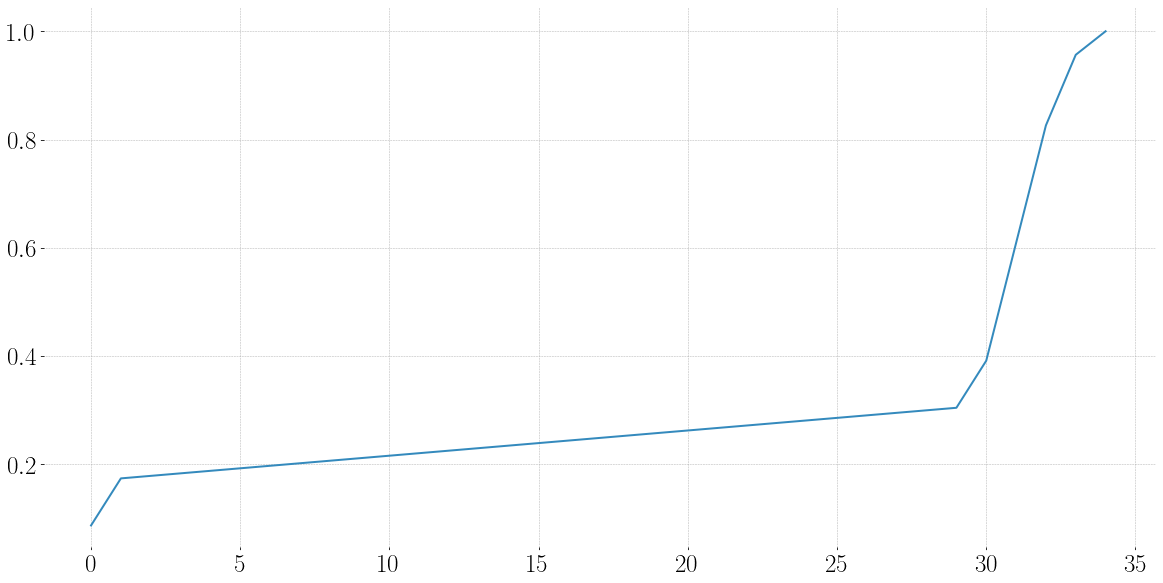

In [72]:
plt.plot(df.index, df['cmf'])

In [113]:
fit = OLS(df.index, df['cmf'])

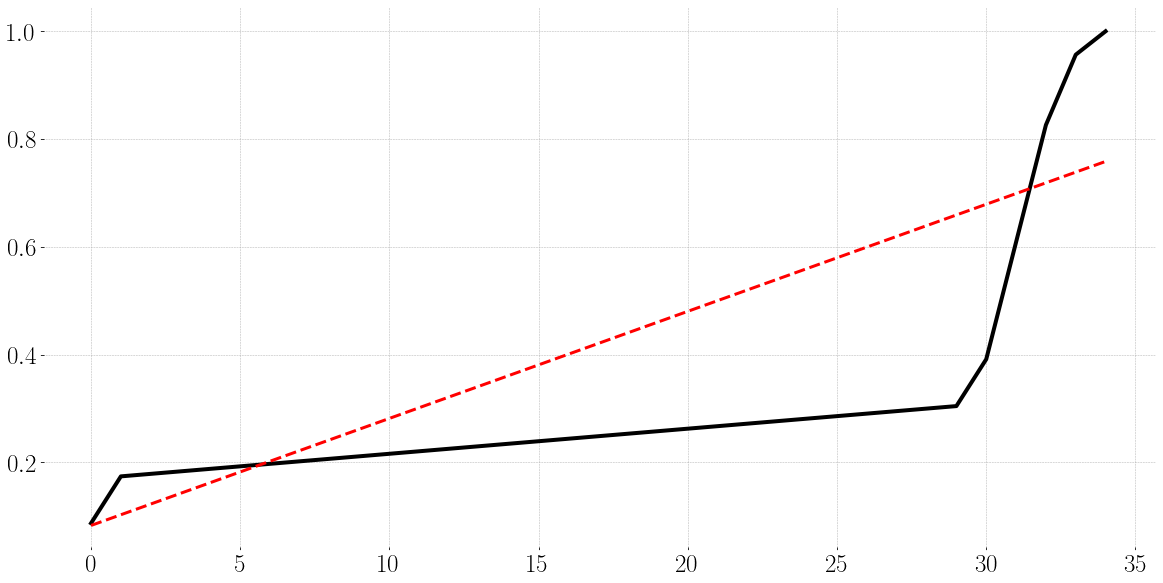

In [74]:
plt.plot(df.index, df['cmf'], ls="solid", c="black", lw=4)
plt.plot(df.index, fit['yh'], ls="dashed", c="red", lw=3)

In [75]:
maxres = 0
pos = None
for i in range(len(fit['res'])):
    if fit['res'][i] > maxres:
        maxres = fit['res'][i]
        pos = i
maxres, pos

(matrix([[0.35471444]]), 2)

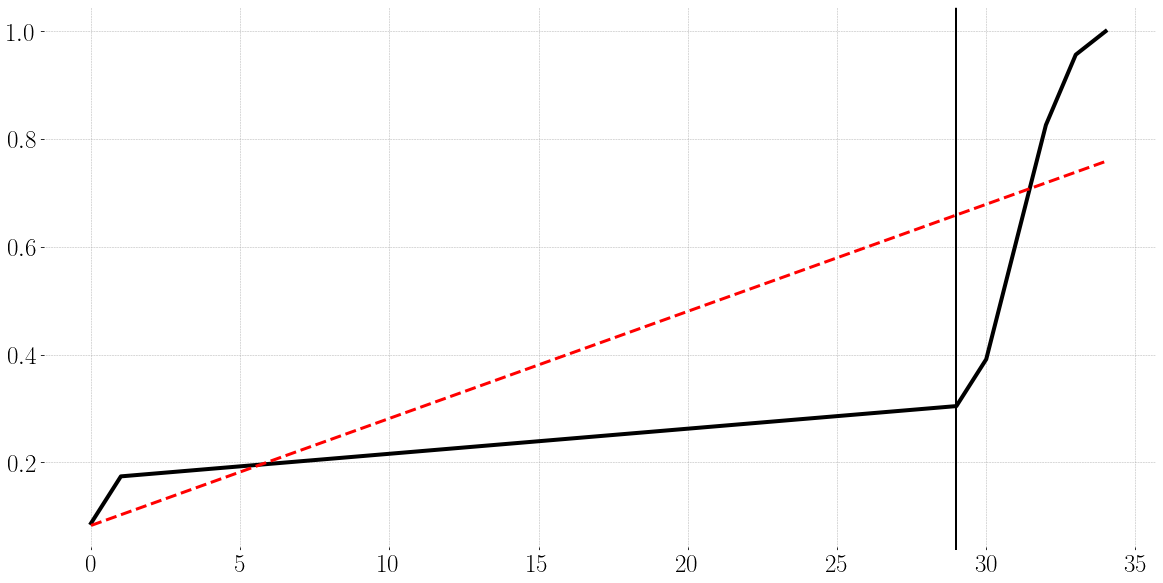

In [76]:
plt.plot(df.index, df['cmf'], ls="solid", c="black", lw=4)
plt.plot(df.index, fit['yh'], ls="dashed", c="red", lw=3)
plt.axvline(list(df.index)[pos], c="black", lw=2)

In [80]:
df2 = df.loc[df.index <= list(df.index)[pos]]
df3 = df.loc[df.index >= list(df.index)[pos]]

In [81]:
fit2 = OLS(df2.index, df2['cmf'])
fit3 = OLS(df3.index, df3['cmf'])

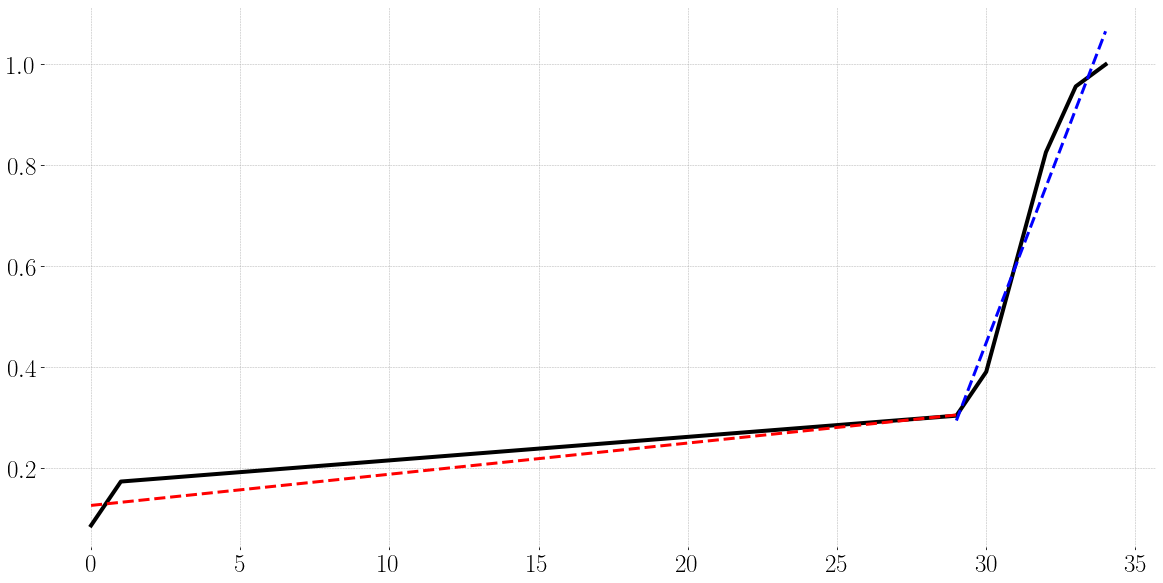

In [82]:
plt.plot(df.index, df['cmf'], ls="solid", c="black", lw=4)
plt.plot(df2.index, fit2['yh'], ls="dashed", c="red", lw=3)
plt.plot(df3.index, fit3['yh'], ls="dashed", c="blue", lw=3)

In [88]:
maxres = 0
pos = None
for i in range(len(fit3['res'])):
    if fit3['res'][i] > maxres:
        maxres = fit3['res'][i]
        pos = i
maxres, pos

(matrix([[0.06875632]]), 2)

In [104]:
a = np.array(fit2['res']).T
b = np.array(fit3['res']).T
resp = np.c_[a, b]
resp

array([[0.03968127, 0.04109845, 0.00141719, 0.00960566, 0.05763397,
        0.06875632, 0.04499494, 0.06572295]])

In [129]:
stats.f_oneway(np.array(fit['sqe']), np.array(resp.T)**2)

F_onewayResult(statistic=array([7.66585337]), pvalue=array([0.01595634]))

In [131]:
F = (np.sum(resp**2) - np.sum(fit['sqe']))  / fit['mse']
F

-6.624664121141105